/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1285 - loss: 1.9890 

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1233 - loss: 1.9970 - val_accuracy: 0.0930 - val_loss: 1.9619
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1632 - loss: 1.9323 - val_accuracy: 0.1163 - val_loss: 1.9462
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2648 - loss: 1.9123 - val_accuracy: 0.3023 - val_loss: 1.9400
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3913 - loss: 1.8578 - val_accuracy: 0.2093 - val_loss: 1.9269
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3594 - loss: 1.7929 - val_accuracy: 0.2791 - val_loss: 1.9488
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3742 - loss: 1.6626 - val_accuracy: 0.2558 - val_loss: 1.8956
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3991 - loss: 1.6191 - val_accuracy: 0.3023 - val_loss: 1.8014
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4219 - loss: 1.4923 - val_accuracy: 0.4186 - val_loss: 1.7214
Epoch 9/10


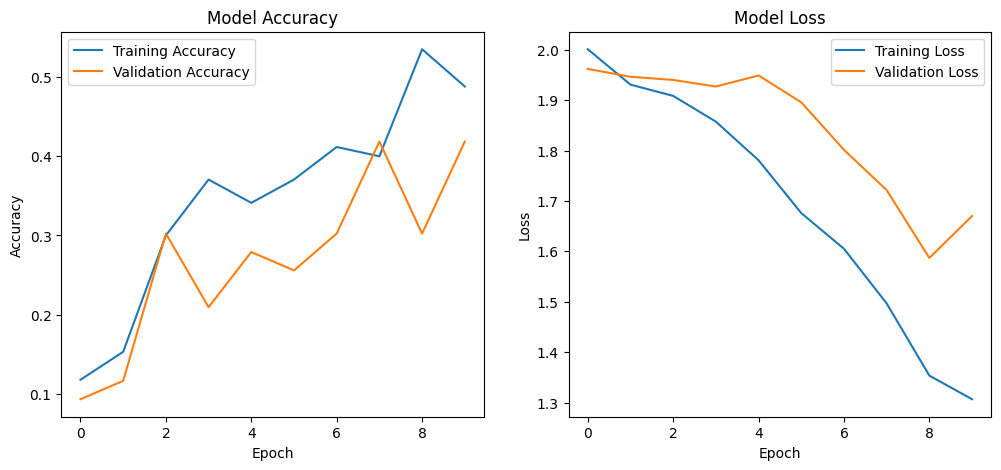

In [12]:

import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

# Define the path to the dataset folder
dataset_folder = r'/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Define the CNN architecture
model = Sequential([
    InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
    Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
    Flatten(),  # Flatten the output for the dense layer
    Dense(100, activation='relu'),  # Fully connected layer
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.2
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using the augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    verbose=1
)

# Evaluate the model and calculate precision, recall, and F1-score
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        try:
            if filename.endswith('.tiff'):
                image_file = os.path.join(folder, filename)
                img = Image.open(image_file).convert('L')
                img = img.resize((64, 64))
                img_array = np.array(img) / 255.0
                images.append(img_array)
                label_code = filename.split('.')[1][:2]
                labels.append(label_map[label_code])
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Define data augmentation configuration
datagen = ImageDataGenerator(shear_range=0.2)
datagen.fit(X_train)

# Generate configurations function
def generate_configurations(num_configs):
    configurations = []
    for i in range(num_configs):
        config = {
            'filters': [32 * 2**j for j in range(random.randint(1, 3))], # 1-3 layers with increasing filter size
            'dense_units': [100 * 2**j for j in range(random.randint(1, 2))], # 1-2 dense layers with increasing units
            'dropout': random.choice([0.3, 0.5]), # Random dropout of 0.3 or 0.5
        }
        configurations.append(config)
    return configurations

configurations = generate_configurations(10) # Generate 10 random configurations
best_configuration = {}
best_accuracy = 0

# Training and evaluating models
for config in configurations:
    try:
        model = Sequential([InputLayer(input_shape=(64, 64, 1))])
        for filters in config['filters']:
            model.add(Conv2D(filters, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        for units in config['dense_units']:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(config['dropout']))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=10, verbose=1)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
        print(f"Configuration: {config}")
        print(f"Test Accuracy: {test_acc * 100:.2f}%")

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_configuration = config
    except Exception as e:
        print(f"Failed configuration {config}: {e}")

# Output best results
print(f"Best Configuration: {best_configuration}")
print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")


Epoch 1/10


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0803 - loss: 3.2312

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.0758 - loss: 3.2444 - val_accuracy: 0.0930 - val_loss: 2.1852
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1796 - loss: 2.1157 - val_accuracy: 0.0930 - val_loss: 1.9967
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1463 - loss: 1.9965 - val_accuracy: 0.0465 - val_loss: 1.9734
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1730 - loss: 1.9414 - val_accuracy: 0.0233 - val_loss: 1.9576
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2464 - loss: 1.9340 - val_accuracy: 0.1395 - val_loss: 2.0398
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1717 - loss: 1.9830 - val_accuracy: 0.2558 - val_loss: 1.9698
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2094 - loss: 1.9383 - val_accuracy: 0.2093 - val_loss: 1.9739
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1837 - loss: 1.9215 - val_accuracy: 0.0930 - val_loss: 1.9793
Epoch 9/10


2024-08-09 00:35:21.069026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64] vs. [0]
	 [[{{function_node __inference_one_step_on_data_75754}}{{node adam/Mul_15}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1014 - loss: 1.9646 - val_accuracy: 0.1163 - val_loss: 1.9571
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1807 - loss: 1.9424 - val_accuracy: 0.1395 - val_loss: 1.9656
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1052 - loss: 1.9537 - val_accuracy: 0.0930 - val_loss: 1.9587
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1296 - loss: 1.9375 - val_accuracy: 0.0930 - val_loss: 1.9594
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1112 - loss: 1.9511 - val_accuracy: 0.0930 - val_loss: 1.9599
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0969 - loss: 1.9482 - val_accuracy: 0.1163 - val_loss: 1.9560
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1672 - loss: 1.9471 - val_accuracy: 0.1395 - val_loss: 1.9538
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1445 - loss: 1.9414 - val_accuracy: 0.1395 - val_loss: 1.9601
Epoch 9/10


In [16]:
import os
import random
import numpy as np
from PIL import Image
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        try:
            if filename.endswith('.tiff'):
                image_file = os.path.join(folder, filename)
                img = Image.open(image_file).convert('L')
                img = img.resize((64, 64))
                img_array = np.array(img) / 255.0
                images.append(img_array)
                label_code = filename.split('.')[1][:2]
                labels.append(label_map[label_code])
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(shear_range=0.2)
datagen.fit(X_train)

# Define the range for configurations
num_conv_layers_options = [1, 2, 3]
num_dense_layers_options = [1, 2]
filters_options = [[32], [64], [32, 64]]
dense_units_options = [[128], [256], [128, 256]]
dropout_options = [0.25, 0.5]

# Generate all possible configurations
def generate_all_configurations():
    configurations = []
    for conv_layers, dense_layers, filters, dense_units, dropout in product(
            num_conv_layers_options, num_dense_layers_options, filters_options, dense_units_options, dropout_options):
        config = {
            'conv_layers': conv_layers,
            'dense_layers': dense_layers,
            'filters': filters,
            'dense_units': dense_units,
            'dropout': dropout
        }
        configurations.append(config)
    return configurations

configurations = generate_all_configurations()
best_configuration = {}
best_accuracy = 0

# Test each configuration
for config in configurations:
    try:
        model = Sequential([InputLayer(input_shape=(64, 64, 1))])
        for i in range(config['conv_layers']):
            model.add(Conv2D(config['filters'][i % len(config['filters'])], (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        for j in range(config['dense_layers']):
            model.add(Dense(config['dense_units'][j % len(config['dense_units'])], activation='relu'))
        model.add(Dropout(config['dropout']))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=10, verbose=1)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
        print(f"Configuration: {config}, Test Accuracy: {test_acc * 100:.2f}%")

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_configuration = config
    except Exception as e:
        print(f"Failed configuration {config}: {e}")

# Output best results
print(f"Best Configuration: {best_configuration}")
print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")


Epoch 1/10


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1215 - loss: 2.3818 

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1240 - loss: 2.5251 - val_accuracy: 0.1395 - val_loss: 2.1199
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1623 - loss: 2.2872 - val_accuracy: 0.1395 - val_loss: 1.9509
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1937 - loss: 1.9485 - val_accuracy: 0.1860 - val_loss: 2.0324
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2889 - loss: 1.8480 - val_accuracy: 0.2093 - val_loss: 1.8713
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3574 - loss: 1.7697 - val_accuracy: 0.3488 - val_loss: 1.8065
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3964 - loss: 1.7007 - val_accuracy: 0.2558 - val_loss: 1.8083
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4594 - loss: 1.6399 - val_accuracy: 0.2791 - val_loss: 1.7521
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4412 - loss: 1.5765 - val_accuracy: 0.3721 - val_loss: 1.6981
Epoch 9/10


In [ ]:
"""Configuration: {'conv_layers': 3, 'dense_layers': 2, 'filters': [32, 64], 'dense_units': [128, 256], 'dropout': 0.5}, Test Accuracy: 16.28%
Best Configuration: {'conv_layers': 1, 'dense_layers': 2, 'filters': [32, 64], 'dense_units': [256], 'dropout': 0.25}
Best Test Accuracy: 58.14%, give the model , normally"""

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger", "DI": "disgust", "FE": "fear",
        "HA": "happiness", "SA": "sadness", "SU": "surprise", "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))
            img_array = np.array(img) / 255.0
            images.append(img_array)
            labels.append(label_map[filename.split('.')[1][:2]])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)
labels = LabelEncoder().fit_transform(labels)
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Setup data augmentation
datagen = ImageDataGenerator(shear_range=0.2)
datagen.fit(X_train)

# Define the range of hyperparameters to optimize
dimensions = [
    Integer(low=1, high=4, name='num_conv_layers'),  # Slightly expanded range
    Integer(low=32, high=256, name='num_filters'),  # Practical range for filters
    Integer(low=64, high=512, name='num_dense_nodes'),  # Expanded dense nodes range
    Real(low=0.1, high=0.5, name='dropout_rate')  # Adjusted dropout range
]

@use_named_args(dimensions=dimensions)
def fitness(num_conv_layers, num_filters, num_dense_nodes, dropout_rate):
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),
        *[layer for i in range(num_conv_layers) for layer in
          [Conv2D(num_filters, (3, 3), activation='relu'), MaxPooling2D((2, 2))]],
        Flatten(),
        Dense(num_dense_nodes, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(labels[0]), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=3, verbose=1, steps_per_epoch=len(X_train) // 32)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return -accuracy

# Perform Bayesian optimization
search_result = gp_minimize(func=fitness, dimensions=dimensions, n_calls=20, x0=[2, 64, 128, 0.25])

# Output the best results
print("Best hyperparameters:")
print("Number of Convolution Layers:", search_result.x[0])
print("Number of Filters:", search_result.x[1])
print("Number of Dense Nodes:", search_result.x[2])
print("Dropout Rate:", search_result.x[3])
print("Best Accuracy Achieved:", -search_result.fun)


In [17]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import tensorflow as tf
from sklearn.model_selection import train_test_split

def set_seeds(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

set_seeds()

def load_images_and_labels(folder):
    images, labels = [], []
    label_map = {"AN": "anger", "DI": "disgust", "FE": "fear", "HA": "happiness",
                 "SA": "sadness", "SU": "surprise", "NE": "neutral"}
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            img = Image.open(os.path.join(folder, filename)).convert('L')
            img_array = np.array(img.resize((64, 64))) / 255.0
            images.append(img_array)
            labels.append(label_map[filename.split('.')[1][:2]])
    return np.array(images).reshape(-1, 64, 64, 1), np.array(labels)
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

images, labels = load_images_and_labels(dataset_folder)
labels = to_categorical(LabelEncoder().fit_transform(labels))
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(shear_range=0.2)
datagen.fit(X_train)

dimensions = [
    Integer(low=1, high=4, name='num_conv_layers'),
    Integer(low=32, high=256, name='num_filters'),
    Integer(low=64, high=512, name='num_dense_nodes'),
    Real(low=0.1, high=0.5, name='dropout_rate')
]

@use_named_args(dimensions=dimensions)
def fitness(num_conv_layers, num_filters, num_dense_nodes, dropout_rate):
    # Initialize the model
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1))
    ])

    # Dynamically add convolution and pooling layers
    for _ in range(num_conv_layers):
        model.add(Conv2D(num_filters, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    # Add flattening, dense, dropout, and output layers
    model.add(Flatten())
    model.add(Dense(num_dense_nodes, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(labels.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model using a data generator
    model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=3, verbose=1,
              steps_per_epoch=max(1, len(X_train) // 32))  # Ensure there are enough steps per epoch

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return -accuracy



search_result = gp_minimize(fitness, dimensions, n_calls=11, x0=[1, 64, 128, 0.3])

print("Best hyperparameters:")
print("Conv Layers:", search_result.x[0])
print("Filters:", search_result.x[1])
print("Dense Nodes:", search_result.x[2])
print("Dropout Rate:", search_result.x[3])
print("Best Accuracy:", -search_result.fun)


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/3
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1976 - loss: 3.4098 

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1427 - loss: 4.1482
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1875 - loss: 2.7741
Epoch 3/3
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2334 - loss: 2.0583

2024-08-09 02:49:46.837021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1933 - loss: 2.0800
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1403 - loss: 1.9582
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 1.9616 
Epoch 3/3
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2031 - loss: 1.9168

2024-08-09 02:49:48.111109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1788 - loss: 1.9421
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1845 - loss: 2.3094
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.1562 - loss: 1.9668
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1342 - loss: 1.9475


2024-08-09 02:49:49.225081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.1546 - loss: 2.0475
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 1.9841 
Epoch 3/3
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1562 - loss: 1.9467

2024-08-09 02:49:51.269999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1496 - loss: 1.9428
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1580 - loss: 1.9738
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.1875 - loss: 1.9713
Epoch 3/3
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2037 - loss: 1.9390

2024-08-09 02:49:52.680568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1888 - loss: 1.9413
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.1568 - loss: 1.9555
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0938 - loss: 2.0601  
Epoch 3/3
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2000 - loss: 1.9677

2024-08-09 02:49:55.997611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.1317 - loss: 1.9510
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2141 - loss: 2.0658
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.2188 - loss: 2.0380
Epoch 3/3
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1452 - loss: 1.9714

2024-08-09 02:49:58.735493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1529 - loss: 1.9647
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.1627 - loss: 1.9786
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0938 - loss: 1.9670  
Epoch 3/3


2024-08-09 02:50:01.957975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.1720 - loss: 1.9467
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1493 - loss: 1.9739
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.1000 - loss: 1.9193
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2425 - loss: 1.9217


2024-08-09 02:50:04.882413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.1287 - loss: 1.9792
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 1.9561  
Epoch 3/3
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.0000e+00 - loss: 1.9770

2024-08-09 02:50:07.756881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.1016 - loss: 1.9522
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1025 - loss: 2.9107
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 2.3693 
Epoch 3/3
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0903 - loss: 2.5630

2024-08-09 02:50:10.550404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1132 - loss: 2.5102
Best hyperparameters:
Conv Layers: 1
Filters: 40
Dense Nodes: 361
Dropout Rate: 0.3093032192621926
Best Accuracy: 0.25581395626068115


In [20]:
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import tensorflow as tf

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Configuration generator function
def generate_unique_configuration(history):
    max_conv_layers = 10  # Increase the maximum number of convolutional layers
    max_dense_layers = 5  # Increase the maximum number of dense layers
    max_filters = [32, 64, 128, 256, 512]  # Add higher filter sizes
    max_dense_units = [128, 256, 512, 1024, 2048]  # Increase dense layer units
    max_dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Increase dropout options
    epoch_range = (10, 50)  # Increase the range for epochs

    while True:
        conv_layers = random.randint(1, min(max_conv_layers, len(max_filters)))
        dense_layers = random.randint(1, min(max_dense_layers, len(max_dense_units)))
        filters = tuple(random.sample(max_filters, conv_layers))
        dense_units = tuple(random.sample(max_dense_units, dense_layers))
        dropout = random.choice(max_dropout)
        epochs = random.randint(*epoch_range)  # Randomly choose epochs within the range

        config = {
            'conv_layers': conv_layers,
            'filters': filters,
            'dense_layers': dense_layers,
            'dense_units': dense_units,
            'dropout': dropout,
            'epochs': epochs  # Include epochs in the configuration
        }

        config_tuple = tuple(sorted((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items()))

        if config_tuple not in history:
            history.add(config_tuple)
            return config

# Generating and evaluating models
history = set()
best_accuracy = 0
best_configuration = None

while True:  # Generate and test 10 unique configurations
    try:
        config = generate_unique_configuration(history)
        model = Sequential()
        model.add(InputLayer(shape=(64, 64, 1)))  # Use 'shape' instead of 'input_shape'
        for i in range(config['conv_layers']):
            model.add(Conv2D(config['filters'][i], (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        for j in range(config['dense_layers']):
            model.add(Dense(config['dense_units'][j], activation='relu'))
        model.add(Dropout(config['dropout']))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=config['epochs'], verbose=0)  # Use the randomly chosen epochs
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Tested Configuration: {config}, Accuracy: {accuracy * 100:.2f}%")
        print(f"Best Configuration: {best_configuration}")
        print(f"Best Accuracy: {best_accuracy * 100:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_configuration = config
    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")

print(f"Best Configuration: {best_configuration}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")


Tested Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16}, Accuracy: 30.23%
Tested Configuration: {'conv_layers': 1, 'filters': (128,), 'dense_layers': 4, 'dense_units': (256, 128, 2048, 1024), 'dropout': 0.1, 'epochs': 11}, Accuracy: 46.51%
Tested Configuration: {'conv_layers': 4, 'filters': (512, 64, 256, 128), 'dense_layers': 1, 'dense_units': (2048,), 'dropout': 0.4, 'epochs': 32}, Accuracy: 51.16%
Tested Configuration: {'conv_layers': 1, 'filters': (512,), 'dense_layers': 4, 'dense_units': (128, 256, 512, 1024), 'dropout': 0.2, 'epochs': 31}, Accuracy: 76.74%
Tested Configuration: {'conv_layers': 2, 'filters': (128, 256), 'dense_layers': 3, 'dense_units': (2048, 1024, 512), 'dropout': 0.1, 'epochs': 40}, Accuracy: 81.40%
Tested Configuration: {'conv_layers': 3, 'filters': (128, 32, 64), 'dense_layers': 5, 'dense_units': (2048, 128, 1024, 256, 512), 'dropout': 0.8, 'epochs': 11}, Accur

In [ ]:
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Data augmentation with shear_range=0.2
datagen = ImageDataGenerator(
    shear_range=0.2
)

datagen.fit(X_train)  # Compute quantities required for featurewise normalization

# Configuration generator function
def generate_unique_configuration(history):
    max_conv_layers = 10  # Increase the maximum number of convolutional layers
    max_dense_layers = 5  # Increase the maximum number of dense layers
    max_filters = [32, 64, 128, 256, 512]  # Add higher filter sizes
    max_dense_units = [128, 256, 512, 1024, 2048]  # Increase dense layer units
    max_dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Increase dropout options
    epoch_range = (10, 50)  # Increase the range for epochs
    batch_size_options = [16, 32, 64, 128]  # Possible batch sizes

    while True:
        conv_layers = random.randint(1, min(max_conv_layers, len(max_filters)))
        dense_layers = random.randint(1, min(max_dense_layers, len(max_dense_units)))
        filters = tuple(random.sample(max_filters, conv_layers))
        dense_units = tuple(random.sample(max_dense_units, dense_layers))
        dropout = random.choice(max_dropout)
        epochs = random.randint(*epoch_range)  # Randomly choose epochs within the range
        batch_size = random.choice(batch_size_options)  # Randomly select a batch size

        config = {
            'conv_layers': conv_layers,
            'filters': filters,
            'dense_layers': dense_layers,
            'dense_units': dense_units,
            'dropout': dropout,
            'epochs': epochs,  # Include epochs in the configuration
            'batch_size': batch_size  # Include batch size in the configuration
        }

        config_tuple = tuple(sorted((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items()))

        if config_tuple not in history:
            history.add(config_tuple)
            return config

# Function to calculate the output size after Conv2D and MaxPooling
def calculate_output_size(input_size, kernel_size, stride=1, padding='valid'):
    if padding == 'same':
        return input_size
    return (input_size - kernel_size) // stride + 1

# Generating and evaluating models
history = set()
best_accuracy = 0
best_configuration = None

for _ in range(10):  # Generate and test 10 unique configurations
    try:
        config = generate_unique_configuration(history)
        model = Sequential()
        model.add(InputLayer(shape=(64, 64, 1)))  # Use 'shape' instead of 'input_shape'
        input_size = 64  # Starting input size

        for i in range(config['conv_layers']):
            if calculate_output_size(input_size, 3) < 1:
                raise ValueError(f"Configuration {config} leads to an invalid layer size.")

            model.add(Conv2D(config['filters'][i], (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D((2, 2)))
            input_size = calculate_output_size(input_size, 2, stride=2)

        model.add(Flatten())
        for j in range(config['dense_layers']):
            model.add(Dense(config['dense_units'][j], activation='relu'))
        model.add(Dropout(config['dropout']))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model using data augmentation with dynamic batch size
        model.fit(datagen.flow(X_train, y_train, batch_size=config['batch_size']), epochs=config['epochs'], verbose=0)

        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Tested Configuration: {config}, Accuracy: {accuracy * 100:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_configuration = config

        print(f"Current Best Accuracy: {best_accuracy * 100:.2f}% with Configuration: {best_configuration}")

    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")

print(f"Final Best Configuration: {best_configuration}")
print(f"Final Best Accuracy: {best_accuracy * 100:.2f}%")


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Tested Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}, Accuracy: 25.58%
Current Best Accuracy: 25.58% with Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}
Tested Configuration: {'conv_layers': 5, 'filters': (128, 64, 512, 32, 256), 'dense_layers': 2, 'dense_units': (512, 128), 'dropout': 0.7, 'epochs': 45, 'batch_size': 16}, Accuracy: 9.30%
Current Best Accuracy: 25.58% with Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}
Tested Configuration: {'conv_layers': 3, 'filters': (128, 512, 32), 'dense_layers': 3, 'dense_units': (1024, 128, 2048), 'dropout': 0.7, 'epochs': 21, 'batch_size': 32}, Accuracy: 9.30%
Current Best Accuracy: 25.5

In [1]:
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Data augmentation with shear_range=0.2
datagen = ImageDataGenerator(
    shear_range=0.2
)

datagen.fit(X_train)  # Compute quantities required for featurewise normalization

# Configuration generator function
def generate_unique_configuration(history):
    max_conv_layers = 10  # Increase the maximum number of convolutional layers
    max_dense_layers = 5  # Increase the maximum number of dense layers
    max_filters = [32, 64, 128, 256, 512]  # Add higher filter sizes
    max_dense_units = [128, 256, 512, 1024, 2048]  # Increase dense layer units
    max_dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Increase dropout options
    epoch_range = (10, 50)  # Increase the range for epochs
    batch_size_options = [16, 32, 64, 128]  # Possible batch sizes

    while True:
        conv_layers = random.randint(1, min(max_conv_layers, len(max_filters)))
        dense_layers = random.randint(1, min(max_dense_layers, len(max_dense_units)))
        filters = tuple(random.sample(max_filters, conv_layers))
        dense_units = tuple(random.sample(max_dense_units, dense_layers))
        dropout = random.choice(max_dropout)
        epochs = random.randint(*epoch_range)  # Randomly choose epochs within the range
        batch_size = random.choice(batch_size_options)  # Randomly select a batch size

        config = {
            'conv_layers': conv_layers,
            'filters': filters,
            'dense_layers': dense_layers,
            'dense_units': dense_units,
            'dropout': dropout,
            'epochs': epochs,  # Include epochs in the configuration
            'batch_size': batch_size  # Include batch size in the configuration
        }

        config_tuple = tuple(sorted((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items()))

        if config_tuple not in history:
            history.add(config_tuple)
            return config

# Function to calculate the output size after Conv2D and MaxPooling
def calculate_output_size(input_size, kernel_size, stride=1, padding='valid'):
    if padding == 'same':
        return input_size
    return (input_size - kernel_size) // stride + 1

# Generating and evaluating models
history = set()
best_accuracy = 0
best_configuration = None

for _ in range(10000):  # Generate and test 10,000 unique configurations
    try:
        config = generate_unique_configuration(history)
        model = Sequential()
        model.add(InputLayer(shape=(64, 64, 1)))  # Use 'shape' instead of 'input_shape'
        input_size = 64  # Starting input size

        for i in range(config['conv_layers']):
            if calculate_output_size(input_size, 3) < 1:
                raise ValueError(f"Configuration {config} leads to an invalid layer size.")

            model.add(Conv2D(config['filters'][i], (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D((2, 2)))
            input_size = calculate_output_size(input_size, 2, stride=2)

        model.add(Flatten())
        for j in range(config['dense_layers']):
            model.add(Dense(config['dense_units'][j], activation='relu'))
        model.add(Dropout(config['dropout']))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model using data augmentation with dynamic batch size
        model.fit(datagen.flow(X_train, y_train, batch_size=config['batch_size']), epochs=config['epochs'], verbose=0)

        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Tested Configuration: {config}, Accuracy: {accuracy * 100:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_configuration = config

        print(f"Current Best Accuracy: {best_accuracy * 100:.2f}% with Configuration: {best_configuration}")

    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")

print(f"Final Best Configuration: {best_configuration}")
print(f"Final Best Accuracy: {best_accuracy * 100:.2f}%")


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Tested Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}, Accuracy: 25.58%
Current Best Accuracy: 25.58% with Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}
Tested Configuration: {'conv_layers': 5, 'filters': (128, 64, 512, 32, 256), 'dense_layers': 2, 'dense_units': (512, 128), 'dropout': 0.7, 'epochs': 45, 'batch_size': 16}, Accuracy: 9.30%
Current Best Accuracy: 25.58% with Configuration: {'conv_layers': 2, 'filters': (32, 128), 'dense_layers': 5, 'dense_units': (128, 1024, 256, 512, 2048), 'dropout': 0.4, 'epochs': 16, 'batch_size': 128}
Tested Configuration: {'conv_layers': 3, 'filters': (128, 512, 32), 'dense_layers': 3, 'dense_units': (1024, 128, 2048), 'dropout': 0.7, 'epochs': 21, 'batch_size': 32}, Accuracy: 9.30%
Current Best Accuracy: 25.5

KeyboardInterrupt: 

In [ ]:
import numpy as np
import os
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Set seed for data augmentation
    tf.keras.utils.set_random_seed(seed)
    # Ensure deterministic behavior in TensorFlow
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Parameter combinations using itertools.product
conv_layers_options = [1, 2]  # Number of convolutional layers
filters_options = [32, 64]  # Number of filters
dense_layers_options = [1, 2]  # Number of dense layers
dense_units_options = [64, 128]  # Number of neurons in dense layers
dropout_options = [0.1, 0.2]  # Dropout rates
epochs_options = [50, 100]  # Number of epochs
batch_size_options = [32, 64]  # Batch sizes

# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2
)

datagen.fit(X_train)

# Generate all configurations
configurations = list(itertools.product(conv_layers_options, filters_options, dense_layers_options,
                                        dense_units_options, dropout_options, epochs_options, batch_size_options))

best_accuracy = 0
best_configuration = None

for config in configurations:
    conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size = config
    try:
        model = Sequential()
        model.add(InputLayer(input_shape=(64, 64, 1)))

        # Adding convolutional layers
        for _ in range(conv_layers):
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())

        # Adding dense layers
        for _ in range(dense_layers):
            model.add(Dense(dense_units, activation='relu'))

        model.add(Dropout(dropout))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model
        model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, verbose=0)

        _, accuracy = model.evaluate(X_test, y_test, verbose=0)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_configuration = config

        print(f"Tested Configuration: {config}, Accuracy: {accuracy * 100:.2f}%")

    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")

print(f"Final Best Configuration: {best_configuration}")
print(f"Final Best Accuracy: {best_accuracy * 100:.2f}%")


# Final Best Configuration: (2, 32, 1, 128, 0.1, 100, 32)
# Final Best Accuracy: 93.02%

In [ ]:
import numpy as np
import os
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
def set_seeds(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the path to the dataset folder
dataset_folder = '/Users/Downloads/linda/JAFFE Dataset'

# Function to load images and labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }
    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Parameter combinations using itertools.product
conv_layers_options = [1, 2, 3]
filters_options = [32, 64]
dense_layers_options = [1, 2]
dense_units_options = [64, 128]
dropout_options = [0.1, 0.2, 0.3]
epochs_options = [50, 100]
batch_size_options = [32, 64]
learning_rate_options = [0.001, 0.002, 0.005, 0.01]  # Different learning rates

# Data augmentation
datagen = ImageDataGenerator(shear_range=0.2)
datagen.fit(X_train)

# Generate all configurations
configurations = list(itertools.product(conv_layers_options, filters_options, dense_layers_options,
                                        dense_units_options, dropout_options, epochs_options,
                                        batch_size_options, learning_rate_options))

best_accuracy = 0
best_configuration = None

for config in configurations:
    conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate = config
    try:
        model = Sequential()
        model.add(InputLayer(input_shape=(64, 64, 1)))

        # Adding convolutional layers
        for _ in range(conv_layers):
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())

        # Adding dense layers
        for _ in range(dense_layers):
            model.add(Dense(dense_units, activation='relu'))

        model.add(Dropout(dropout))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        # Define the optimizer with a custom learning rate
        optimizer = Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model
        model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, verbose=0)

        _, accuracy = model.evaluate(X_test, y_test, verbose=0)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_configuration = config

        print(f"Tested Configuration: {config}, Accuracy: {accuracy * 100:.2f}%")

    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")

print(f"Final Best Configuration: {best_configuration}")
print(f"Final Best Accuracy: {best_accuracy * 100:.2f}%")


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Tested Configuration: (1, 32, 1, 64, 0.1, 50, 32, 0.001), Accuracy: 46.51%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 32, 0.002), Accuracy: 62.79%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 32, 0.005), Accuracy: 86.05%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 32, 0.01), Accuracy: 60.47%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 64, 0.001), Accuracy: 53.49%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 64, 0.002), Accuracy: 81.40%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 64, 0.005), Accuracy: 74.42%
Tested Configuration: (1, 32, 1, 64, 0.1, 50, 64, 0.01), Accuracy: 9.30%
Tested Configuration: (1, 32, 1, 64, 0.1, 100, 32, 0.001), Accuracy: 81.40%
Tested Configuration: (1, 32, 1, 64, 0.1, 100, 32, 0.002), Accuracy: 60.47%
Tested Configuration: (1, 32, 1, 64, 0.1, 100, 32, 0.005), Accuracy: 81.40%
Tested Configuration: (1, 32, 1, 64, 0.1, 100, 32, 0.01), Accuracy: 9.30%
Tested Configuration: (1, 32, 1, 64, 0.1, 100, 64, 0.001), Accuracy: 79.07%
Tested Configuration: (1,

2024-08-09 17:55:03.525237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [7]
	 [[{{function_node __inference_one_step_on_data_618194}}{{node adam/truediv_15}}]]


An error occurred with configuration (1, 32, 2, 128, 0.3, 100, 64, 0.001): Graph execution error:

Detected at node adam/truediv_15 defined at (most recent call last):
  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/asyncio/base_events.py", line 603, i

2024-08-09 18:27:57.626403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:20025: Filling up shuffle buffer (this may take a while): 3 of 8
2024-08-09 18:27:57.628187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Tested Configuration: (1, 64, 1, 64, 0.2, 50, 64, 0.002), Accuracy: 62.79%
Tested Configuration: (1, 64, 1, 64, 0.2, 50, 64, 0.005), Accuracy: 79.07%
Tested Configuration: (1, 64, 1, 64, 0.2, 50, 64, 0.01), Accuracy: 9.30%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 32, 0.001), Accuracy: 74.42%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 32, 0.002), Accuracy: 76.74%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 32, 0.005), Accuracy: 86.05%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 32, 0.01), Accuracy: 9.30%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 64, 0.001), Accuracy: 86.05%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 64, 0.002), Accuracy: 81.40%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 64, 0.005), Accuracy: 79.07%
Tested Configuration: (1, 64, 1, 64, 0.2, 100, 64, 0.01), Accuracy: 9.30%
Tested Configuration: (1, 64, 1, 64, 0.3, 50, 32, 0.001), Accuracy: 65.12%
Tested Configuration: (1, 64, 1, 64, 0.3, 50, 32, 0.002), Accuracy: 20.93%
Tested Configuration: (